In [1]:
import chaindetection
import plot
import numpy as np
import scipy
import scipy.cluster
import math
import sklearn
import matplotlib.pyplot as plt
import dataloader
import collections

In [2]:
if __name__ == '__main__':   
    var = 0.3 #for clusters
    wantedDist = 0.05 #for spline
    eps=.3
    min_samples=4
    runs = 50
    debug = 0
    
    for jitter in [.3]: #for spline    
        print(f"Running Jitter {jitter}", flush=True)
        name = f"avg nmi score hierarchyCluster var {var}, wantedDist {wantedDist}, jitter {jitter}, eps {eps}, min_samples {min_samples}, runs {runs}"
        
        def DBSCANclustering(points):
            return sklearn.cluster.DBSCAN(eps=eps, min_samples=min_samples).fit(points).labels_

        def hierarchyCluster(points):
            y = scipy.spatial.distance.pdist([p for p in points])
            Z = scipy.cluster.hierarchy.single(y)
            return scipy.cluster.hierarchy.fcluster(Z, eps, criterion='distance')

        clusteringAlgo = hierarchyCluster
        nmi_scores = []
        while len(nmi_scores) < runs:
            points, trueLabels = dataloader.random2cluster(var, wantedDist, jitter)

            if debug: plot.plot(points, trueLabels, dotSize=5, saveFigure = True)
            labels = clusteringAlgo(points)
            if debug: plot.plot(points, labels, title=f"clusteringAlgo {nmi}", dotSize=5)
            if max(np.bincount(labels)) < 1000:
                print("X", end="", flush=True)
                continue
            nmi = sklearn.metrics.normalized_mutual_info_score(trueLabels, labels, average_method='arithmetic')
            

            allowedVars = np.linspace(0, 1, 50)
            nmis = []
            for allowedVar in allowedVars:
                labelsCD = chaindetection.chainDetection(points, [l for l in labels], eps, allowedVar, clusteringAlgo, chainDim=1)
                if debug>=2: plot.plot(points, labelsCD, title=f"Chaindetection, allowedVar: {allowedVar}")
                nmi = sklearn.metrics.normalized_mutual_info_score(trueLabels, labelsCD, average_method='arithmetic')
                nmis.append(nmi)
            if debug: 
                plt.show()
                plt.scatter(allowedVars, nmis)
                plt.show()
            nmi_scores.append(nmis)
            print(".", end="", flush=True)
        np.save(name, np.array(nmi_scores))
        avg_scores = sum([np.array(n) for n in nmi_scores]) / len(nmi_scores)


Running Jitter 0.3
.XX.X.X..X.X..XXXX..X..XX.XXXX.XX....XXXXX.XXXX.XX.....X.XX.XX.XXX...XX.X..XXXX.XXX..X....X.X..X.X.XX.X..XX.

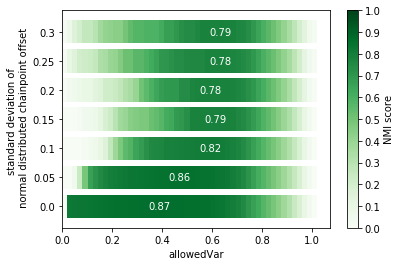

In [6]:
import matplotlib as mpl
import matplotlib.cm as cm

for i,jitter in enumerate(["0", "05", "1", "15", "2", "25", "3"]):
    nmi_scores = np.load(f"avg nmi score hierarchyCluster var 0.3, wantedDist 0.05, jitter 0.{jitter}, eps 0.3, min_samples 4, runs 50.npy")
    avg_scores = sum([np.array(n) for n in nmi_scores]) / len(nmi_scores)
    barwidth = allowedVars[1] - allowedVars[0]
    plt.barh(f"0.{jitter}", [barwidth] * len(avg_scores), color=[cm.Greens(i) for i in avg_scores], left=allowedVars)
    bestIndex = np.where(avg_scores == max(avg_scores))[0][0]
    plt.text(bestIndex*barwidth, f"0.{jitter}", "%2.2f" % max(avg_scores), ha='center', va='center', color="white")
plt.xlabel("allowedVar")
plt.ylabel("standard deviation of \n normal distributed chainpoint offset")
#plt.title("NMI score for different chain densities and allowedVar parameters")
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('Greens',100), norm=mpl.colors.Normalize(vmin=0,vmax=1))
sm.set_array([])
plt.colorbar(sm, ticks=np.arange(0,1.001,.1), 
             boundaries=np.arange(0,1.001,.001)).set_label("NMI score")
plt.savefig("allowedVarRobustness.png")
